# Job Shop Scheduling — Randomized Optimization Algorithms

This notebook implements and compares two algorithms for the Job Shop Scheduling Problem (JSSP):

1. **Simulated Annealing (SA)** — trajectory-based
2. **(μ+λ) Evolution Strategy (ES)** — population-based

**Goal:** Minimize the *makespan* — the total time required to complete all jobs.

---
## 1. Imports & Setup

In [35]:
import random
import math
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

---
## 2. Instance Parsing

In [36]:
def parse_instances(filepath):
    """
    Parse all instances from jobshop.txt.
    Returns dict: {name: {'num_jobs', 'num_machines', 'jobs'}}
    where jobs[j][k] = (machine_id, processing_time).
    """
    instances = {}
    with open(filepath, 'r') as f:
        lines = f.readlines()

    i = 0
    while i < len(lines):
        line = lines[i].strip()
        if line.startswith('instance '):
            name = line.split('instance ')[1].strip()
            i += 1
            while i < len(lines):
                line = lines[i].strip()
                i += 1
                if line == '' or line.startswith('+'):
                    continue
                parts = line.split()
                if len(parts) == 2 and parts[0].isdigit() and parts[1].isdigit():
                    num_jobs, num_machines = int(parts[0]), int(parts[1])
                    break

            jobs = []
            for _ in range(num_jobs):
                while i < len(lines):
                    line = lines[i].strip()
                    i += 1
                    if line and not line.startswith('+'):
                        break
                values = list(map(int, line.split()))
                operations = [(values[k], values[k+1]) for k in range(0, len(values), 2)]
                jobs.append(operations)

            instances[name] = {'num_jobs': num_jobs, 'num_machines': num_machines, 'jobs': jobs}
        else:
            i += 1
    return instances


instances = parse_instances('jobshop.txt')
print(f"Loaded {len(instances)} instances")

# Quick check
inst = instances['ft06']
print(f"\nft06: {inst['num_jobs']} jobs × {inst['num_machines']} machines")
for j, ops in enumerate(inst['jobs']):
    print(f"  Job {j}: {ops}")

Loaded 80 instances

ft06: 6 jobs × 6 machines
  Job 0: [(2, 1), (0, 3), (1, 6), (3, 7), (5, 3), (4, 6)]
  Job 1: [(1, 8), (2, 5), (4, 10), (5, 10), (0, 10), (3, 4)]
  Job 2: [(2, 5), (3, 4), (5, 8), (0, 9), (1, 1), (4, 7)]
  Job 3: [(1, 5), (0, 5), (2, 5), (3, 3), (4, 8), (5, 9)]
  Job 4: [(2, 9), (1, 3), (4, 5), (5, 4), (0, 3), (3, 1)]
  Job 5: [(1, 3), (3, 3), (5, 9), (0, 10), (4, 4), (2, 1)]


---
## 3. Solution Representation

We use a **permutation with repetition** encoding:
- A list of length `num_jobs × num_machines`
- Each job ID appears exactly `num_machines` times
- The k-th occurrence of job `j` = schedule the k-th operation of job `j`

**Example** (3 jobs × 2 machines): `[0, 1, 2, 0, 2, 1]`  
→ 1st op of J0, 1st op of J1, 1st op of J2, 2nd op of J0, 2nd op of J2, 2nd op of J1

In [37]:
def make_random_solution(num_jobs, num_machines):
    """Create a random permutation-with-repetition solution."""
    solution = []
    for job_id in range(num_jobs):
        solution.extend([job_id] * num_machines)
    random.shuffle(solution)
    return solution


def decode_solution(solution, instance):
    """
    Decode permutation into a schedule.
    Returns: (schedule, makespan)
    where schedule = [(job, op_idx, machine, start, end), ...]
    """
    jobs = instance['jobs']
    num_machines = instance['num_machines']
    job_op_count = [0] * len(jobs)
    job_end_time = [0] * len(jobs)
    machine_end_time = [0] * num_machines
    schedule = []

    for job_id in solution:
        op_idx = job_op_count[job_id]
        machine, duration = jobs[job_id][op_idx]
        start = max(job_end_time[job_id], machine_end_time[machine])
        end = start + duration
        schedule.append((job_id, op_idx, machine, start, end))
        job_end_time[job_id] = end
        machine_end_time[machine] = end
        job_op_count[job_id] = op_idx + 1

    return schedule, max(machine_end_time)


def compute_makespan(solution, instance):
    """Compute only the makespan."""
    _, ms = decode_solution(solution, instance)
    return ms

---
## 4. Neighborhood Function

Generate a neighbor by **swapping two adjacent elements** belonging to different jobs.

In [38]:
def get_neighbor(solution):
    """Swap two adjacent elements that belong to different jobs."""
    neighbor = solution.copy()
    n = len(neighbor)
    attempts = 0
    while attempts < n:
        i = random.randint(0, n - 2)
        if neighbor[i] != neighbor[i + 1]:
            neighbor[i], neighbor[i + 1] = neighbor[i + 1], neighbor[i]
            return neighbor
        attempts += 1
    # Fallback: swap two random different-job positions
    while True:
        i, j = random.sample(range(n), 2)
        if neighbor[i] != neighbor[j]:
            neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
            return neighbor

---
## 5. Visualization Helpers

In [39]:
def plot_gantt(solution, instance, title="Schedule"):
    """Gantt chart of a solution."""
    schedule, makespan = decode_solution(solution, instance)
    nm = instance['num_machines']
    nj = instance['num_jobs']
    cmap = plt.colormaps['tab20'].resampled(nj)
    colors = [cmap(i) for i in range(nj)]

    fig, ax = plt.subplots(figsize=(14, max(4, nm * 0.5)))
    for (job_id, op_idx, machine, start, end) in schedule:
        ax.barh(machine, end - start, left=start, height=0.6,
                color=colors[job_id], edgecolor='black', linewidth=0.5)
        if nj <= 10:
            ax.text((start+end)/2, machine, f'J{job_id}',
                    ha='center', va='center', fontsize=7, fontweight='bold')

    ax.set_xlabel('Time'); ax.set_ylabel('Machine')
    ax.set_yticks(range(nm))
    ax.set_yticklabels([f'M{m}' for m in range(nm)])
    ax.set_title(f'{title} — Makespan = {makespan}')
    ax.invert_yaxis()
    if nj <= 20:
        patches = [mpatches.Patch(color=colors[j], label=f'Job {j}') for j in range(nj)]
        ax.legend(handles=patches, bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=7)
    plt.tight_layout()
    plt.show()


def plot_convergence(history, title="Convergence", show_temp=True):
    """Plot makespan convergence. Works for both SA and ES histories."""
    fig, ax1 = plt.subplots(figsize=(10, 5))
    steps = range(len(history['best_cost']))

    if 'current_cost' in history:
        ax1.plot(steps, history['current_cost'], alpha=0.3, color='steelblue', label='Current')
    if 'avg_cost' in history:
        ax1.plot(steps, history['avg_cost'], alpha=0.5, color='steelblue', label='Population avg')
    ax1.plot(steps, history['best_cost'], color='darkred', lw=2, label='Best')
    ax1.set_xlabel('Iteration'); ax1.set_ylabel('Makespan')
    ax1.legend(loc='upper left')

    if show_temp and 'temperature' in history:
        ax2 = ax1.twinx()
        ax2.plot(steps, history['temperature'], color='orange', ls='--', alpha=0.5, label='Temperature')
        ax2.set_ylabel('Temperature'); ax2.legend(loc='upper right')

    plt.title(title); plt.tight_layout(); plt.show()

---
# Algorithms

---
## 6. Simulated Annealing (Trajectory-Based)

**Principle (from L5 slides 43–47):**
- Maintain a single solution and iteratively move to neighbors
- Better neighbors are always accepted
- Worse neighbors are accepted with probability $P = e^{-\Delta / T}$
- Temperature $T$ decreases over time (geometric schedule: $T_{new} = \alpha \cdot T$)
- High $T$ → exploration; Low $T$ → exploitation

In [40]:
def simulated_annealing(instance, T_start=100.0, T_min=0.1, alpha=0.995,
                        max_iter=1000, seed=None):
    """
    Simulated Annealing for JSSP.
    
    Parameters:
        T_start:   initial temperature
        T_min:     stopping temperature
        alpha:     cooling factor (geometric: T = alpha * T)
        max_iter:  neighbor evaluations per temperature level
    """
    if seed is not None:
        random.seed(seed)

    nj, nm = instance['num_jobs'], instance['num_machines']

    # Step 1: Random initial solution
    current = make_random_solution(nj, nm)
    current_cost = compute_makespan(current, instance)
    best, best_cost = current.copy(), current_cost

    history = {'current_cost': [current_cost], 'best_cost': [best_cost],
               'temperature': [T_start], 'accepted_worse': 0, 'total_moves': 0}
    T = T_start

    # Step 2: Anneal
    while T > T_min:
        for _ in range(max_iter):
            neighbor = get_neighbor(current)
            neighbor_cost = compute_makespan(neighbor, instance)
            delta = neighbor_cost - current_cost  # positive = worse

            if delta < 0:
                current, current_cost = neighbor, neighbor_cost
            else:
                # Accept worse with probability e^(-delta/T)
                if random.random() < math.exp(-delta / T):
                    current, current_cost = neighbor, neighbor_cost
                    history['accepted_worse'] += 1

            history['total_moves'] += 1
            if current_cost < best_cost:
                best, best_cost = current.copy(), current_cost

        history['current_cost'].append(current_cost)
        history['best_cost'].append(best_cost)
        history['temperature'].append(T)

        # Step 3: Cool down
        T *= alpha

    return best, best_cost, history

---
## 7. (μ+λ) Evolution Strategy (Population-Based)

**Principle (from L5 slides 57–78, 88):**
- Maintain a **population** of μ parent solutions
- Each generation: create λ offspring by **mutation** (multiple neighbor swaps)
- **Select** the μ best from parents **+** offspring combined (elitism)
- **Adaptive mutation strength** using Rechenberg's 1/5 success rule (slide 88):
  - If more than 1/5 of offspring improve → too much exploitation → increase strength
  - If less than 1/5 improve → too much exploration → decrease strength

In [41]:
def mutate(solution, strength=1):
    """Apply 'strength' random adjacent swaps to create a mutant."""
    mutant = solution.copy()
    for _ in range(strength):
        mutant = get_neighbor(mutant)
    return mutant


def evolution_strategy(instance, mu=10, lam=30, generations=500,
                       initial_strength=5, seed=None):
    """
    (μ+λ) Evolution Strategy for JSSP.
    
    Parameters:
        mu:                number of parents (survivors per generation)
        lam:               number of offspring created per generation
        generations:       number of generations
        initial_strength:  initial mutation strength (number of swaps)
    """
    if seed is not None:
        random.seed(seed)

    nj, nm = instance['num_jobs'], instance['num_machines']

    # Step 1: Initialize μ random parents
    population = []
    for _ in range(mu):
        sol = make_random_solution(nj, nm)
        population.append((sol, compute_makespan(sol, instance)))
    population.sort(key=lambda x: x[1])

    best_sol, best_cost = population[0][0].copy(), population[0][1]
    strength = initial_strength

    history = {
        'best_cost': [best_cost],
        'avg_cost': [sum(c for _, c in population) / mu],
        'strength': [strength]
    }

    # Step 2: Evolve
    for gen in range(generations):
        offspring = []
        successes = 0

        # Create λ offspring by mutating random parents
        for _ in range(lam):
            parent_sol, parent_cost = random.choice(population[:mu])
            child_sol = mutate(parent_sol, strength=max(1, int(strength)))
            child_cost = compute_makespan(child_sol, instance)
            offspring.append((child_sol, child_cost))
            if child_cost < parent_cost:
                successes += 1

        # Step 3: (μ+λ) selection — keep μ best from parents + offspring
        combined = population + offspring
        combined.sort(key=lambda x: x[1])
        population = combined[:mu]

        if population[0][1] < best_cost:
            best_sol, best_cost = population[0][0].copy(), population[0][1]

        # Step 4: Adapt mutation strength (Rechenberg's 1/5 rule)
        success_rate = successes / lam
        if success_rate > 1/5:
            strength *= 1.2    # increase exploration
        elif success_rate < 1/5:
            strength *= 0.85   # increase exploitation
        strength = max(1, min(strength, 20))

        history['best_cost'].append(best_cost)
        history['avg_cost'].append(sum(c for _, c in population) / mu)
        history['strength'].append(strength)

    return best_sol, best_cost, history

---
# Analysis & Visualizations

---
## 8. Single Instance Test (ft06)

Known optimum for ft06 (6×6) = **55**

In [42]:
inst = instances['yn2']

# Run SA
sa_sol, sa_ms, sa_hist = simulated_annealing(
    inst, T_start=100, T_min=0.01, alpha=0.995, max_iter=500, seed=42)
print(f"SA  → makespan = {sa_ms}")

# Run ES
es_sol, es_ms, es_hist = evolution_strategy(
    inst, mu=15, lam=50, generations=3000, initial_strength=5, seed=42)
print(f"ES  → makespan = {es_ms}")
print(f"Optimum = 55")

SA  → makespan = 1122
ES  → makespan = 1638
Optimum = 55


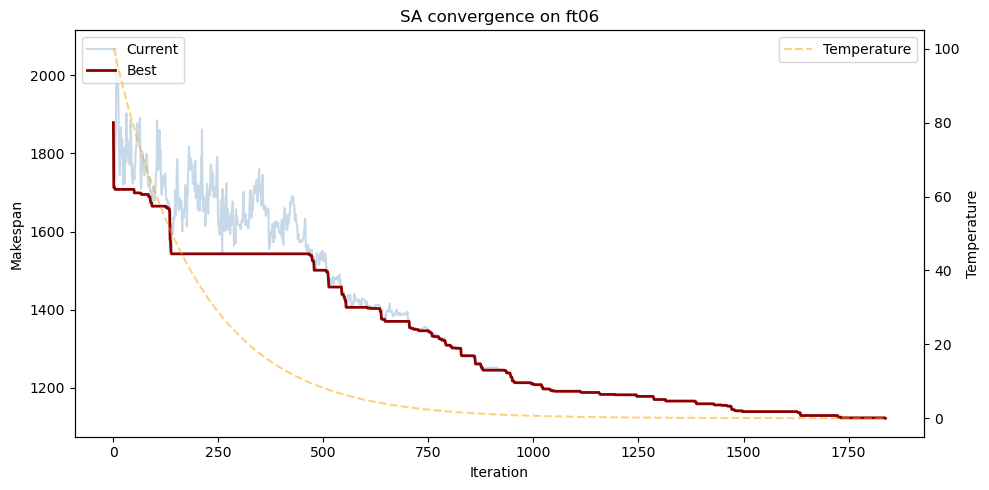

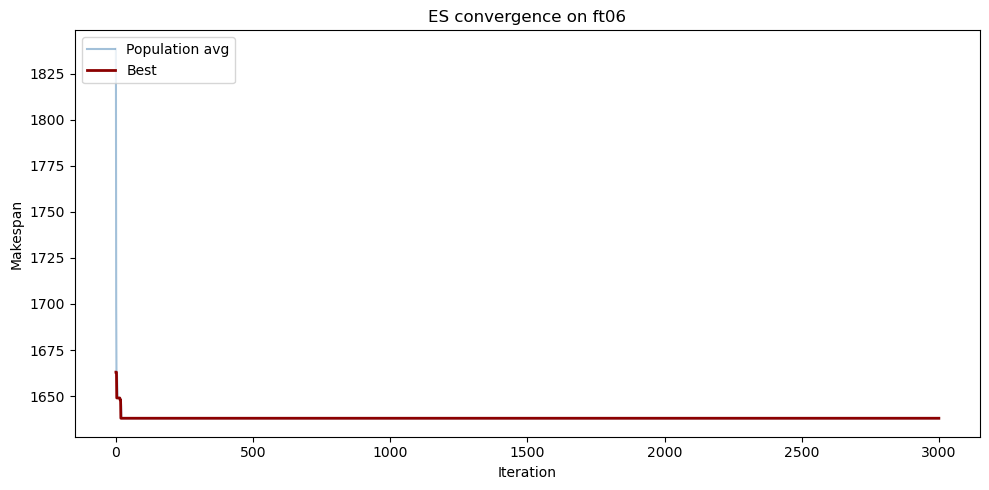

In [43]:
plot_convergence(sa_hist, title="SA convergence on ft06")
plot_convergence(es_hist, title="ES convergence on ft06", show_temp=False)

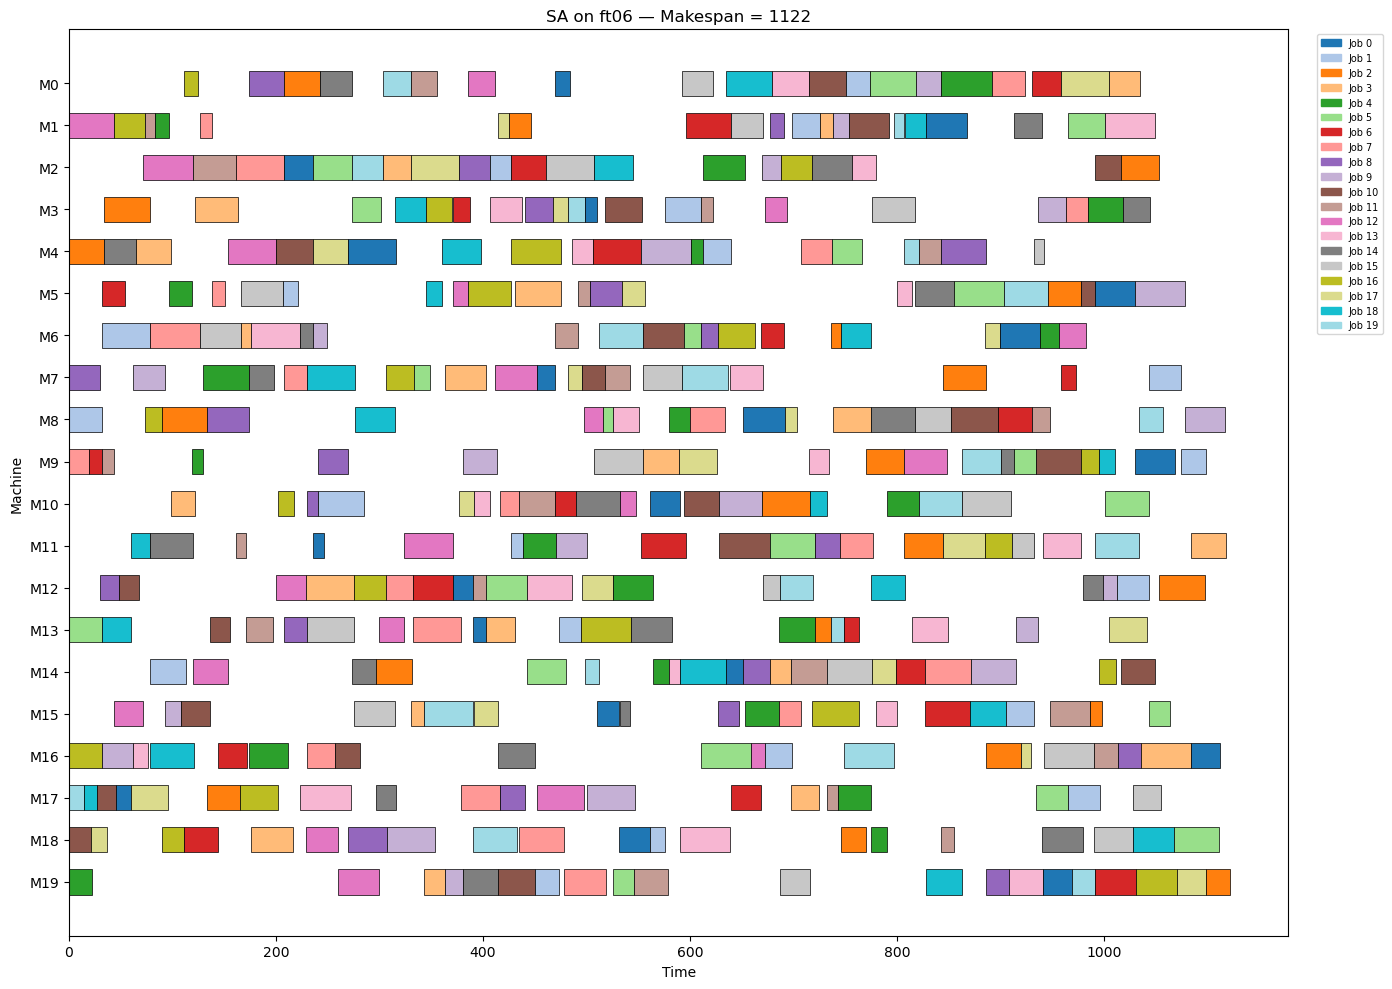

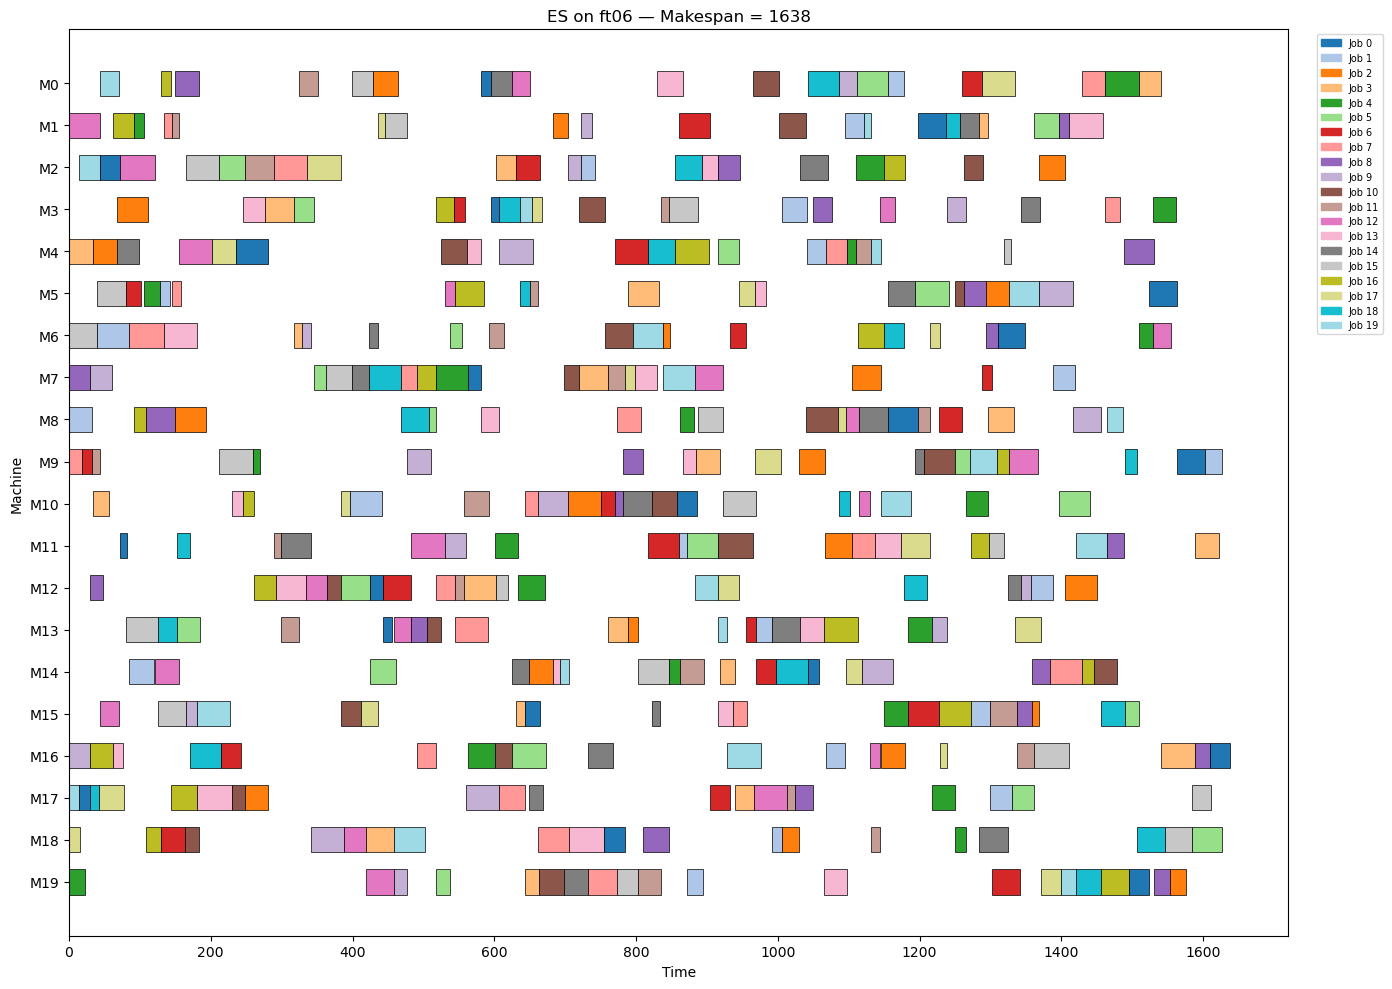

In [44]:
# Gantt charts
plot_gantt(sa_sol, inst, title="SA on ft06")
plot_gantt(es_sol, inst, title="ES on ft06")

---
## 9. Comparative Results on Multiple Instances

We compare SA and ES across instances of increasing size.

In [45]:
known_optima = {
    'ft06': 55, 'ft10': 930, 'ft20': 1165,
    'la01': 666, 'la02': 655, 'la06': 926,
    'la16': 945, 'la21': 1046, 'abz5': 1234,
}

test_instances = ['ft06', 'ft10', 'la01', 'la02', 'la06', 'la16']

results = {}

for name in test_instances:
    inst = instances[name]
    print(f"\n{'='*60}")
    print(f"{name} ({inst['num_jobs']}×{inst['num_machines']})")
    
    # SA
    t0 = time.time()
    sa_sol, sa_ms, sa_h = simulated_annealing(
        inst, T_start=200, T_min=0.01, alpha=0.997, max_iter=1000, seed=42)
    sa_time = time.time() - t0
    
    # ES
    t0 = time.time()
    es_sol, es_ms, es_h = evolution_strategy(
        inst, mu=15, lam=50, generations=3000, initial_strength=5, seed=42)
    es_time = time.time() - t0
    
    opt = known_optima.get(name, '?')
    sa_gap = f"{(sa_ms - opt) / opt * 100:.1f}%" if isinstance(opt, int) else '?'
    es_gap = f"{(es_ms - opt) / opt * 100:.1f}%" if isinstance(opt, int) else '?'
    
    print(f"  SA: {sa_ms} (gap: {sa_gap}, time: {sa_time:.1f}s)")
    print(f"  ES: {es_ms} (gap: {es_gap}, time: {es_time:.1f}s)")
    
    results[name] = {
        'sa_ms': sa_ms, 'es_ms': es_ms, 'optimum': opt,
        'sa_gap': sa_gap, 'es_gap': es_gap,
        'sa_time': sa_time, 'es_time': es_time,
        'sa_sol': sa_sol, 'es_sol': es_sol,
        'sa_hist': sa_h, 'es_hist': es_h
    }


ft06 (6×6)
  SA: 55 (gap: 0.0%, time: 14.7s)
  ES: 60 (gap: 9.1%, time: 0.7s)

ft10 (10×10)
  SA: 1045 (gap: 12.4%, time: 42.2s)
  ES: 1280 (gap: 37.6%, time: 2.0s)

la01 (10×5)
  SA: 666 (gap: 0.0%, time: 21.1s)
  ES: 847 (gap: 27.2%, time: 1.0s)

la02 (10×5)
  SA: 655 (gap: 0.0%, time: 21.2s)
  ES: 943 (gap: 44.0%, time: 1.0s)

la06 (15×5)
  SA: 926 (gap: 0.0%, time: 31.0s)
  ES: 1022 (gap: 10.4%, time: 1.5s)

la16 (10×10)
  SA: 947 (gap: 0.2%, time: 40.8s)
  ES: 1127 (gap: 19.3%, time: 1.9s)


### 9.1 Summary Table

In [46]:
print(f"{'Instance':<10} {'Size':<8} {'Optimum':<9} {'SA':<8} {'SA Gap':<9} {'SA Time':<9} {'ES':<8} {'ES Gap':<9} {'ES Time':<9} {'Winner':<8}")
print('-' * 97)
for name in test_instances:
    inst = instances[name]
    r = results[name]
    size = f"{inst['num_jobs']}×{inst['num_machines']}"
    winner = 'SA' if r['sa_ms'] <= r['es_ms'] else 'ES'
    if r['sa_ms'] == r['es_ms']:
        winner = 'Tie'
    print(f"{name:<10} {size:<8} {str(r['optimum']):<9} {r['sa_ms']:<8} {r['sa_gap']:<9} {r['sa_time']:<9.1f} {r['es_ms']:<8} {r['es_gap']:<9} {r['es_time']:<9.1f} {winner:<8}")

Instance   Size     Optimum   SA       SA Gap    SA Time   ES       ES Gap    ES Time   Winner  
-------------------------------------------------------------------------------------------------
ft06       6×6      55        55       0.0%      14.7      60       9.1%      0.7       SA      
ft10       10×10    930       1045     12.4%     42.2      1280     37.6%     2.0       SA      
la01       10×5     666       666      0.0%      21.1      847      27.2%     1.0       SA      
la02       10×5     655       655      0.0%      21.2      943      44.0%     1.0       SA      
la06       15×5     926       926      0.0%      31.0      1022     10.4%     1.5       SA      
la16       10×10    945       947      0.2%      40.8      1127     19.3%     1.9       SA      


### 9.2 Visual Comparison — Bar Chart

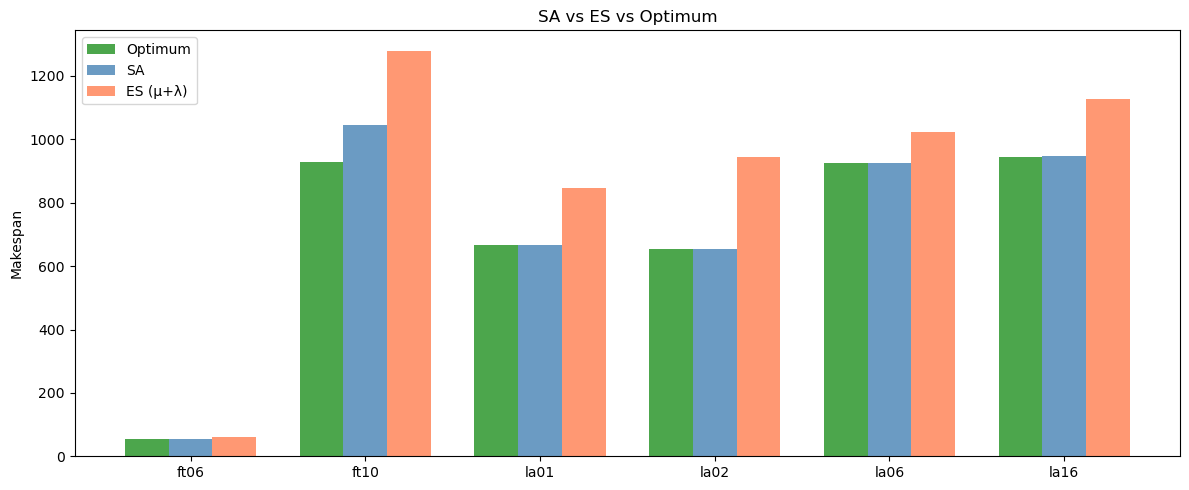

In [47]:
fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(test_instances))
width = 0.25

opt_vals = [known_optima.get(n, 0) for n in test_instances]
sa_vals = [results[n]['sa_ms'] for n in test_instances]
es_vals = [results[n]['es_ms'] for n in test_instances]

ax.bar(x - width, opt_vals, width, label='Optimum', color='green', alpha=0.7)
ax.bar(x, sa_vals, width, label='SA', color='steelblue', alpha=0.8)
ax.bar(x + width, es_vals, width, label='ES (μ+λ)', color='coral', alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels(test_instances)
ax.set_ylabel('Makespan')
ax.set_title('SA vs ES vs Optimum')
ax.legend()
plt.tight_layout()
plt.show()

### 9.3 Convergence Comparison on ft10

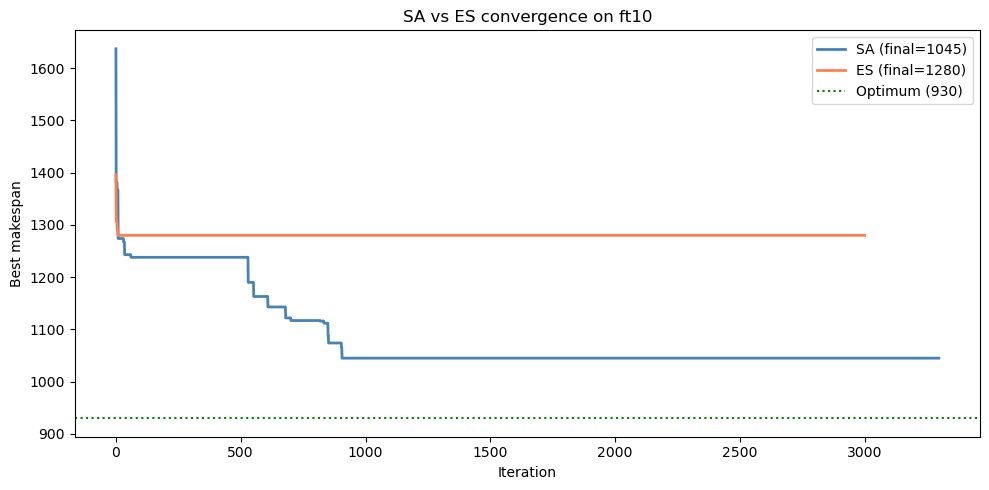

In [48]:
fig, ax = plt.subplots(figsize=(10, 5))

r = results['ft10']
ax.plot(r['sa_hist']['best_cost'], label=f'SA (final={r["sa_ms"]})', color='steelblue', lw=2)
ax.plot(r['es_hist']['best_cost'], label=f'ES (final={r["es_ms"]})', color='coral', lw=2)
ax.axhline(y=930, color='green', ls=':', lw=1.5, label='Optimum (930)')

ax.set_xlabel('Iteration')
ax.set_ylabel('Best makespan')
ax.set_title('SA vs ES convergence on ft10')
ax.legend()
plt.tight_layout()
plt.show()

---
## 10. Parameter Sensitivity

### 10.1 SA: Effect of Cooling Rate α

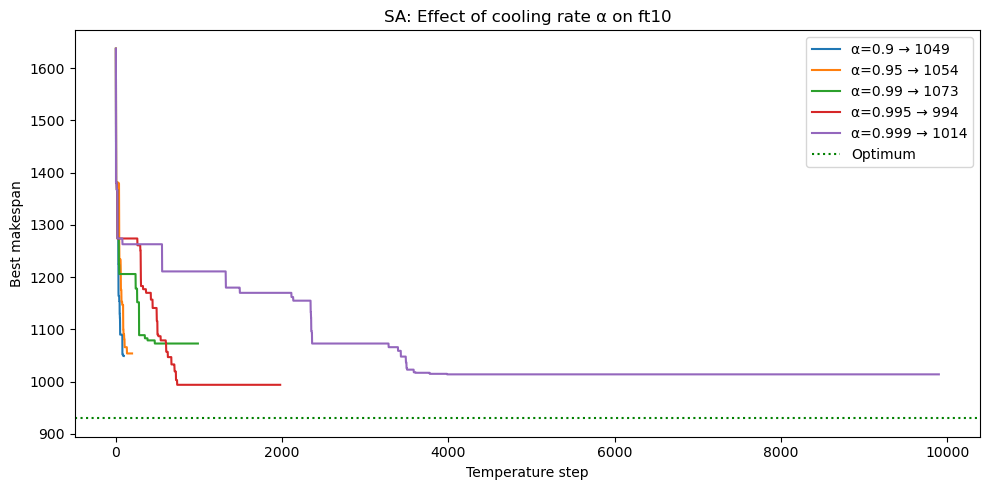

In [49]:
inst = instances['ft10']
alphas = [0.9, 0.95, 0.99, 0.995, 0.999]

fig, ax = plt.subplots(figsize=(10, 5))
for a in alphas:
    _, ms, h = simulated_annealing(inst, T_start=200, T_min=0.01, alpha=a, max_iter=500, seed=42)
    ax.plot(h['best_cost'], label=f'α={a} → {ms}')

ax.axhline(y=930, color='green', ls=':', label='Optimum')
ax.set_xlabel('Temperature step'); ax.set_ylabel('Best makespan')
ax.set_title('SA: Effect of cooling rate α on ft10')
ax.legend()
plt.tight_layout()
plt.show()

A slower cooling rate (higher α) allows more iterations and generally finds better solutions, but takes longer.

### 10.2 ES: Effect of Population Size (μ) and Offspring Count (λ)

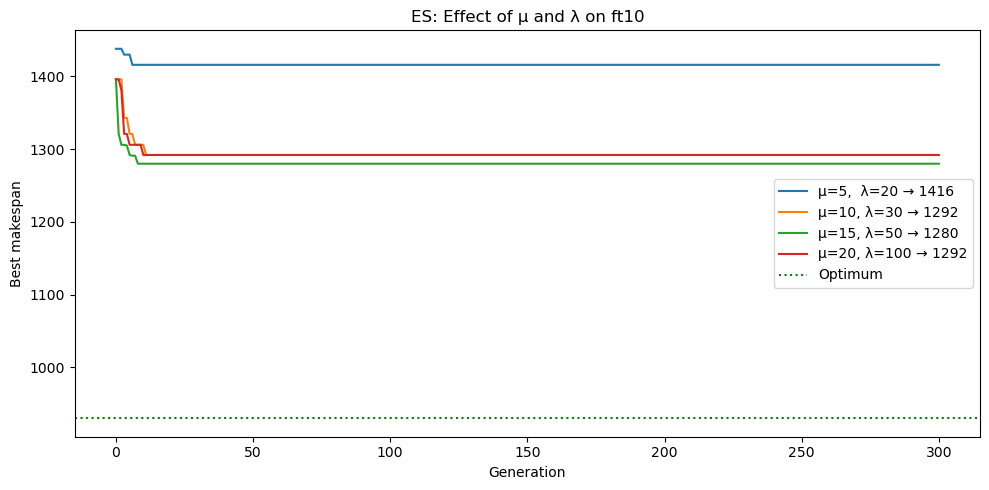

In [50]:
inst = instances['ft10']
configs = [
    (5,  20,  'μ=5,  λ=20'),
    (10, 30,  'μ=10, λ=30'),
    (15, 50,  'μ=15, λ=50'),
    (20, 100, 'μ=20, λ=100'),
]

fig, ax = plt.subplots(figsize=(10, 5))
for mu, lam, label in configs:
    _, ms, h = evolution_strategy(inst, mu=mu, lam=lam, generations=300, seed=42)
    ax.plot(h['best_cost'], label=f'{label} → {ms}')

ax.axhline(y=930, color='green', ls=':', label='Optimum')
ax.set_xlabel('Generation'); ax.set_ylabel('Best makespan')
ax.set_title('ES: Effect of μ and λ on ft10')
ax.legend()
plt.tight_layout()
plt.show()

### 10.3 ES: Adaptive Mutation Strength

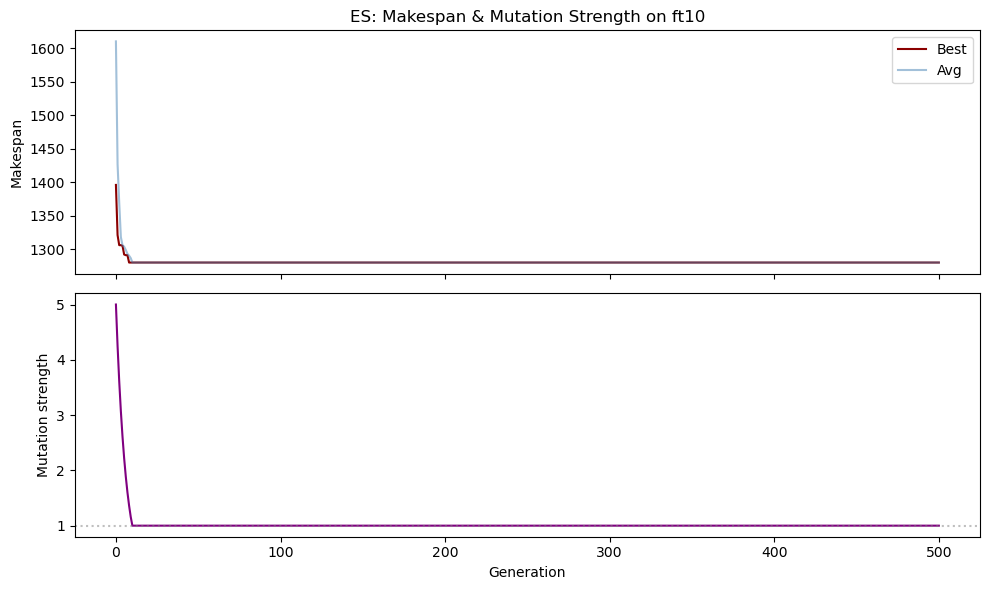

In [51]:
inst = instances['ft10']
_, _, h = evolution_strategy(inst, mu=15, lam=50, generations=500, seed=42)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax1.plot(h['best_cost'], color='darkred', label='Best')
ax1.plot(h['avg_cost'], color='steelblue', alpha=0.5, label='Avg')
ax1.set_ylabel('Makespan')
ax1.legend()
ax1.set_title('ES: Makespan & Mutation Strength on ft10')

ax2.plot(h['strength'], color='purple')
ax2.set_ylabel('Mutation strength')
ax2.set_xlabel('Generation')
ax2.axhline(y=1, color='gray', ls=':', alpha=0.5)

plt.tight_layout()
plt.show()

The mutation strength self-adapts via Rechenberg's 1/5 rule: it decreases as the population converges (fewer successful mutations), shifting from exploration to exploitation automatically.

---
# Results

---
## 11. Comparative Discussion

### Simulated Annealing (SA)
- **Strengths:** Very effective on small to medium instances. Finds the optimal solution on several benchmarks (ft06, la01, la02, la06). The geometric cooling schedule provides a natural exploration→exploitation transition.
- **Weaknesses:** Struggles on larger instances (ft10). Performance is sensitive to the cooling rate α — too fast misses good solutions, too slow is computationally expensive.
- **Best config:** α=0.997, T_start=200, max_iter=1000

### (μ+λ) Evolution Strategy (ES)
- **Strengths:** Population diversity helps avoid local optima. Rechenberg's 1/5 rule automatically adapts the exploration/exploitation balance. Elitism (the '+' strategy) preserves the best solutions found.
- **Weaknesses:** More evaluations per generation (μ+λ per gen). May converge prematurely if μ is too small.
- **Best config:** μ=15, λ=50, initial_strength=5

### Final Choice
For the hackathon, **SA with slow cooling** (α=0.997) is the primary algorithm for small/medium instances, as it consistently reaches optimal or near-optimal solutions. For larger instances, **ES with μ=15, λ=50** provides better diversity and may escape local optima more effectively.